In [1]:
import os
from math import sqrt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Flatten, BatchNormalization, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow_probability import distributions as tfd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import ipywidgets as widgets
from IPython.display import display, clear_output
from joblib import load

from utils import *
from constants import *
from models import *

## Display Results

## Display Results

In [60]:
results = pd.read_csv('results.csv')

# Print results
for idx, row in results.iterrows():
    print("Model:", row['Model Name'])
    for metric, value in row.items():
        if metric != 'Model Name':
            print(f"{metric:50} {value if isinstance(value, str) else round(value, 2)}")
    print("\n")

Model: Non-probabilistic MLP
Train RMSE                                         27.43
Train MAE                                          16.39
Test RMSE                                          27.97
Test MAE                                           16.68
Test % within 99.00% CI                            96.22726192676294


Model: Epistemic Uncertainty BNN (Flipout) - 1.0% Sample
Train RMSE                                         124.99
Train MAE                                          92.54
Test RMSE                                          124.93
Test MAE                                           92.37
Test % within 99.00% CI                            17.168730364073184


Model: Epistemic Uncertainty BNN (Flipout)
Train RMSE                                         29.38
Train MAE                                          18.14
Test RMSE                                          29.74
Test MAE                                           18.25
Test % within 99.00% CI                   

In [61]:
# Format results to be added to a latex table.

results = pd.read_csv('results.csv')

metrics = results.columns[1:]

for idx, row in results.iterrows():
    formatted_line = ""
    for i, metric in enumerate(metrics):
        value = row[metric]
        # Try converting string values to floats
        try:
            value = float(value)
        except ValueError:
            pass 
        # Format the value to two decimal places
        formatted_value = "{:.2f}".format(value) if isinstance(value, float) else value
        if i == len(metrics) - 1:
            formatted_value += "\%" 
        
        formatted_line += f" & {formatted_value}"
        if i == 0:
            formatted_line = str(row['Model Name']) + " " + formatted_value
    print(formatted_line + " \\\\")
    print("\n")

Non-probabilistic MLP 27.43 & 16.39 & 27.97 & 16.68 & 96.23\% \\


Epistemic Uncertainty BNN (Flipout) - 1.0% Sample 124.99 & 92.54 & 124.93 & 92.37 & 17.17\% \\


Epistemic Uncertainty BNN (Flipout) 29.38 & 18.14 & 29.74 & 18.25 & 25.59\% \\


Stochastic Output BNN (Flipout) 569.53 & 368.60 & 569.11 & 367.50 & 7.82\% \\


Probabilistic MLP (Separate Sub-models) 49.15 & 30.16 & 49.05 & 30.07 & 93.31\% \\


Probabilistic MLP (Joint Sub-models) 67.34 & 41.09 & 66.86 & 40.81 & 98.02\% \\


Probabilistic CNN with Gaussian Output 271.13 & 192.23 & 270.53 & 192.03 & 99.92\% \\


Non-Bayesian Multivariate (Only Diagonal) 237.36 & 173.29 & 237.74 & 174.52 & 88.11\% \\


Probabilistic Multivariate MLP (Only Diagonal) 426.07 & 295.08 & 430.43 & 299.52 & 11.94\% \\


Probabilistic Multivariate MLP (Lower Triangular Covariance Matrix) 943.51 & 687.71 & 955.25 & 699.34 & 2.50\% \\


GP (RBF, only-wind) 65.46 & 46.60 & 68.85 & 46.52 & -\% \\


RBF 26.22 & 18.21 & 45.47 & 29.61 & -\% \\


Matern 13.4

## Additional Plots

In [2]:
DATA_PATH = "."

df_train = pd.read_pickle(open(DATA_PATH + '/cleaned_data_train.pkl','rb'))
df_test = pd.read_pickle(open(DATA_PATH + '/cleaned_data_test.pkl','rb'))

In [3]:
print("Full Training Set Size: ", df_train.shape[0])
print("Full Testing Set Size: ", df_test.shape[0])

df_train_single = df_train[df_train['turbine'] == TURBINE_ID]#.reset_index(drop=True, inplace=True)
df_test_single = df_test[df_test['turbine'] == TURBINE_ID]#.reset_index(drop=True, inplace=True)
df_train_single.reset_index(drop=True, inplace=True)
print("Turbine#{TURBINE_ID} Training Set Size: ", df_train.shape[0])
print("Turbine#{TURBINE_ID} Testing Set Size: ", df_test.shape[0])
df = pd.concat([df_train_single, df_test_single])

Full Training Set Size:  807764
Full Testing Set Size:  201943
Turbine#{TURBINE_ID} Training Set Size:  807764
Turbine#{TURBINE_ID} Testing Set Size:  201943


In [5]:
X_train, X_test, \
    y_train, y_test, \
    scaler = create_design_matrix(df_train_single, df_test_single, FEATURES, OUTPUT_FEATURE)

In [104]:
df_preds = pd.read_csv('preds.csv')

bnn_pred = np.array(df_preds.loc[df_preds['Model Name'] == 'Stochastic Output BNN (Flipout)', 'y_test_pred'].tolist())
bnn_stddevs = np.array(df_preds.loc[df_preds['Model Name'] == 'Stochastic Output BNN (Flipout)', 'y_test_stddevs'].tolist())
mlp_pred = np.array(df_preds.loc[df_preds['Model Name'] == 'Prob. MLP', 'y_test_pred'].tolist())
mlp_stddevs = np.array(df_preds.loc[df_preds['Model Name'] == 'Prob. MLP', 'y_test_stddevs'].tolist())
gp_pred = np.array(df_preds.loc[df_preds['Model Name'] == 'GP (RBF, sparse)', 'y_test_pred'].tolist())
gp_stddevs = np.array(df_preds.loc[df_preds['Model Name'] == 'GP (RBF, sparse)', 'y_test_stddevs'].tolist())
mlp_ft_pred = np.array(df_preds.loc[df_preds['Model Name'] == 'Prob. MLP (Fine-tuned)', 'y_test_pred'].tolist())
mlp_ft_stddevs = np.array(df_preds.loc[df_preds['Model Name'] == 'Prob. MLP (Fine-tuned)', 'y_test_stddevs'].tolist())
lmlp_pred = np.array(df_preds.loc[df_preds['Model Name'] == 'Large Prob. MLP', 'y_test_pred'].tolist())
lmlp_stddevs = np.array(df_preds.loc[df_preds['Model Name'] == 'Large Prob. MLP', 'y_test_stddevs'].tolist())
lmlp_ft_pred = np.array(df_preds.loc[df_preds['Model Name'] == 'Large Prob. MLP (Fine-tuned)', 'y_test_pred'].tolist())
lmlp_ft_stddevs = np.array(df_preds.loc[df_preds['Model Name'] == 'Large Prob. MLP (Fine-tuned)', 'y_test_stddevs'].tolist())

y_test_pred_list = [gp_pred,
                    bnn_pred,
                    mlp_pred,
                    mlp_ft_pred,
                    lmlp_pred,
                    lmlp_ft_pred]

y_test_std_list = [gp_stddevs,
                    bnn_stddevs,
                    mlp_stddevs,
                    mlp_ft_stddevs,
                    lmlp_stddevs,
                    lmlp_ft_stddevs]

y_test_list = [y_test,
                y_test,
                y_test,
                y_test,
                y_test,
                y_test]

titles = ["GP (RBF, sparse)",
            "BNN",
            "PMLP",
            "PMLP (with pre-training)",
            "LPMLP",
            "LPMLP (with pre-training)"]

In [86]:
def calc_percentages_in_interval(y_test, y_test_pred, y_test_stddevs, ci):
    z_value = stats.norm.ppf((1 + ci) / 2) 

    test_lower_bound = y_test_pred - z_value * y_test_stddevs
    test_upper_bound = y_test_pred + z_value * y_test_stddevs

    test_within_interval = np.sum(np.logical_and(y_test.ravel() >= test_lower_bound, y_test.ravel() <= test_upper_bound))

    test_percentage_within_interval = (test_within_interval / len(y_test.ravel())) * 100
    return test_percentage_within_interval

for i in range(len(y_test_list)):
    print(titles[i], round(calc_percentages_in_interval(y_test, y_test_pred_list[i], y_test_std_list[i], 0.95), 2))

GP (RBF, sparse) 94.31
BNN 94.7
PMLP 94.37
PMLP (with
pre-training) 95.19
LPMLP 93.96
LPMLP (with
pre-training) 93.38


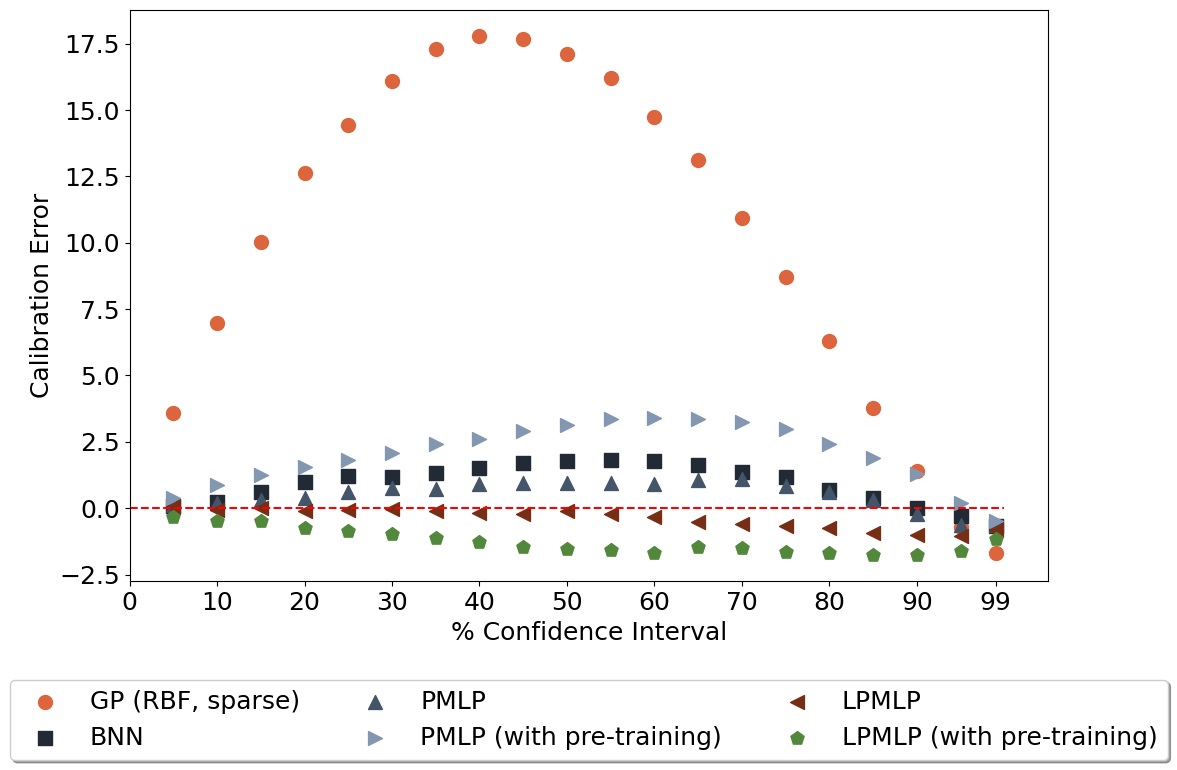

In [105]:
def plot_confidence_interval_combined(y_test_pred_list, y_test_std_list, y_test_list, bins=20, titles=None, save_path=None):
    plt.rc('font', size=18)
    fig, ax = plt.subplots(figsize=(12, 8))

    p_values = np.array([stats.norm.ppf(i/bins + (1-i/bins)/2) for i in range(1, bins)]).squeeze()
    t_values = np.concatenate((p_values, np.array([stats.norm.ppf(0.995)])))
    markers = ['o', 's', '^', '>', '<', 'p', 'h']
    colors = ['#DC653D', '#222A35', '#445469', '#8497B0', '#772E15', '#52883B', '#9A46D4']

    ax.plot([0, 100], [0, 0], color='red', linestyle='--')

    for i, (y_test_pred, y_test_std, y_test) in enumerate(zip(y_test_pred_list, y_test_std_list, y_test_list)):
        actual_percentages = np.concatenate((np.arange(1, bins)*100/bins, np.array([99])))
        percentages_within_interval = []
        for t_value in t_values:
            lower_bounds = y_test_pred.ravel() - t_value * y_test_std
            upper_bounds = y_test_pred.ravel() + t_value * y_test_std

            is_within_interval = np.logical_and(y_test >= lower_bounds, y_test <= upper_bounds)
            num_within_interval = np.sum(is_within_interval)
            percentage_within_interval = (num_within_interval / len(y_test)) * 100
            percentages_within_interval.append(percentage_within_interval)
        calibration_error = np.array(percentages_within_interval) - actual_percentages
        ax.scatter(actual_percentages, calibration_error, marker=markers[i], color=colors[i], label=titles[i], s=100)

    ax.set_xlim(0, 105)
    ax.set_xticks(list(range(0, 91, 10)) + [99])
    ax.set_xlabel('% Confidence Interval', fontsize=18)
    ax.set_ylabel('Calibration Error', fontsize=18)

    # Adjust the subplot parameters to make room for the legend at the bottom
    plt.subplots_adjust(bottom=0.2)

    # Place the legend at the bottom outside the plot
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3, fontsize=18)

    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()


plot_confidence_interval_combined(y_test_pred_list, y_test_std_list, y_test_list, bins=20, titles=titles) 

## Interactive QQ plot

In [95]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = "/content/drive/My Drive/Colab Notebooks/FYP/UK Wind Turbines"

df = pd.read_pickle(open(DATA_PATH + '/cleaned_data.pkl','rb'))

In [96]:
df = df[df['turbine'] == TURBINE_ID]
df = df.dropna(subset=FEATURES + [OUTPUT_FEATURE] + [DATETIME_COL])
df.reset_index(drop=True, inplace=True)


In [97]:
def get_live_data(df, start_index=-144, end_index=None):
    df_live = df[start_index:end_index]

    X_live, y_live = df_live[FEATURES].to_numpy(), df_live[OUTPUT_FEATURE].to_numpy()

    scaler = load('saved_models/scaler.joblib')
    X_live = scaler.transform(X_live)
    X_live.shape
    return X_live, y_live

In [83]:
X_live, y_live = get_live_data(df, start_index=-144)

In [99]:
model = create_model_mlp_gaussian_large(X_live, 42)
model.summary()

model.load_weights('saved_models/mlp_large_finetuned.keras')
evaluation = model.evaluate(X_live, y_live)
print("Evaluation Loss:", evaluation)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 34)]              0         
                                                                 
 dense (Dense)               (None, 300)               10500     
                                                                 
 dense_1 (Dense)             (None, 200)               60200     
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 2)                 202       
                                                                 
 distribution_lambda (Distr  ((None, 1),               0         
 ibutionLambda)               (None, 1))                         
                                                            

In [101]:
y_live_pred = np.array(model(X_live).mean()).ravel()
y_live_stddevs = np.array(model(X_live).stddev()).ravel()

save_preds(None, y_live_pred, y_live_stddevs)

evaluate_and_save_metrics(None,
    y_live, y_live, y_live_pred, y_live_pred,
    y_live_stddevs, y_live_stddevs, 0.99)

Train RMSE: 22.218
Test RMSE: 22.218
Train MAE: 11.059
Test MAE: 11.059
97.22%
97.22%


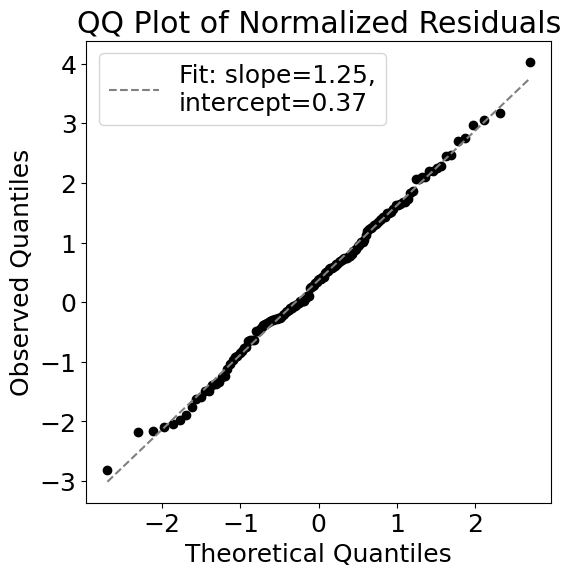

In [101]:
def qq_plot(normalized_residuals, ci=0.99):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)

    z_value = stats.norm.ppf((1 + ci) / 2)

    # Calculate theoretical quantiles and observed quantiles
    theoretical_quantiles = stats.norm.ppf(np.linspace(0.5/len(normalized_residuals), 1-0.5/len(normalized_residuals), len(normalized_residuals)))
    observed_quantiles = np.sort(normalized_residuals)
    lower_bound = 0 - z_value 
    upper_bound = 0 + z_value
    out_of_confidence_indices = np.where(~np.logical_and(observed_quantiles >= lower_bound, observed_quantiles <= upper_bound))[0]

    ax.plot(theoretical_quantiles, observed_quantiles, 'o', color='black')

    # Highlight specific points in a different color
    # ax.plot(theoretical_quantiles[out_of_confidence_indices], observed_quantiles[out_of_confidence_indices], 'o', color='red', label=f'Outside C.I. {ci*100:.1f}%')

    # Plot the line of best fit
    slope, intercept, _, _, _ = stats.linregress(theoretical_quantiles, observed_quantiles)
    line = slope * theoretical_quantiles + intercept
    ax.plot(theoretical_quantiles, line, color='gray', linestyle='--', label=f'Fit: slope={slope:.2f},\nintercept={intercept:.2f}')

    ax.set_title('QQ Plot of Normalized Residuals')
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Observed Quantiles')
    plt.legend(loc='upper left')
    plt.show()


def update_plot(start_index, end_index, ci):
        if end_index <= start_index:
            clear_output(wait=True)
            print("Error: End index must be greater than start index.")
            return
        
        clear_output(wait=True)
        
        X_live, y_live = get_live_data(df, start_index, end_index)
        
        y_live_pred = np.array(model(X_live).mean()).ravel()
        y_live_stddevs = np.array(model(X_live).stddev()).ravel()  
        
        normalized_residuals = (y_live - y_live_pred) / y_live_stddevs
        
        qq_plot(normalized_residuals, ci)

def interactive_qq_plot(df, model):
    start_index_widget = widgets.IntText(value=230, description='Start Index:', continuous_update=False)
    end_index_widget = widgets.IntText(value=374, description='End Index:', continuous_update=False)
    ci_widget = widgets.FloatSlider(value=0.99, min=0.90, max=0.999, step=0.001, description='Confidence Interval:', continuous_update=False)
    
    interact_manual = widgets.interactive(update_plot, start_index=start_index_widget, end_index=end_index_widget, ci=ci_widget)
    
    display(interact_manual)

# interactive_qq_plot(df, model)
    

X_live, y_live = get_live_data(df, 230, 374)

y_live_pred = np.array(model(X_live).mean()).ravel()
y_live_stddevs = np.array(model(X_live).stddev()).ravel()  

normalized_residuals = (y_live - y_live_pred) / y_live_stddevs

qq_plot(normalized_residuals, 0.99)